# Measure AMT quality using NLI models

In [ ]:
pip install -q transformers sentencepiece sentence-transformers transquest unbabel-comet

     |████████████████████████████████| 4.9 MB 10.4 MB/s 
     |████████████████████████████████| 1.3 MB 59.2 MB/s 
     |████████████████████████████████| 85 kB 5.4 MB/s 
     |████████████████████████████████| 211 kB 67.0 MB/s 
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 120 kB 73.2 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
     |████████████████████████████████| 1.8 MB 55.8 MB/s 
     |████████████████████████████████| 125 kB 76.0 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 4.9 MB 45.9 MB/s 
     |████████████████████████████████| 116 kB 55.8 MB/s 
     |████████████████████████████████| 409 kB 49.9 MB/s 
     |████████████████████████████████| 585 kB 12.2 MB/s 
     |████████████████████████████████| 9.5 MB 51.3 MB/s 
     |████████████████████████████████| 101 kB 9.3 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |█████████████████

In [ ]:
import pandas as pd
human_feedback = pd.read_csv("drive/MyDrive/diplomka/webnlg_translation_human_feedback.csv")

In [ ]:
translations_gtranslate = {}
for _,row in human_feedback[human_feedback["engine"] == "google translate"].iterrows():
    translations_gtranslate[row["lex"]] = row["translation"]

translations_cubbitt = {}
for _,row in human_feedback[human_feedback["engine"] == "cubbitt"].iterrows():
    translations_cubbitt[row["lex"]] = row["translation"]

grouped_human_feedback = []
for _,row in human_feedback[human_feedback["engine"] == "deepl"].iterrows():
    grouped_human_feedback.append({
        "adequacy" : row["adequacy"],
        "fluency": row["fluency"],
        "lex": row["lex"],
        "translation": row["translation"],
        "translation_gtranslate": translations_gtranslate[row["lex"]],
        "translation_cubbitt": translations_cubbitt[row["lex"]],
    })
grouped_human_feedback = pd.DataFrame(grouped_human_feedback)

In [ ]:
grouped_human_feedback

,adequacy,fluency,lex,translation,translation_gtranslate,translation_cubbitt
0,5.0,5.0,Alfredo Zitarrosa's musical genre is Candombe.,Hudebním žánrem Alfreda Zitarrosy je Candombe.,Hudební žánr Alfreda Zitarrosy je Candombe.,Hudební žánr Alfreda Zitarrosy je Candombe.
1,5.0,5.0,The musical genre of Alfredo Zitarrosa is Cand...,Hudebním žánrem Alfreda Zitarrosy je candombe.,Hudební žánr Alfreda Zitarrosy je Candombe.,Hudebním žánrem Alfreda Zitarrosy je Candombe.
2,4.0,5.0,"ENAIRE, in the city of Madrid, is the operator...",Společnost ENAIRE se sídlem v Madridu je provo...,ENAIRE ve městě Madrid je provozovatelem letiš...,Společnost ENAIRE je ve městě Madrid provozova...
3,5.0,5.0,"Adolfo Suárez Madrid–Barajas Airport, is locat...",Letiště Adolfa Suáreze Madrid-Barajas se nachá...,Letiště Adolfa Suáreze Madrid–Barajas se nachá...,"Adolfo Suárez Madrid–Barajas Airport, se nachá..."
4,5.0,4.0,A Wizard of Mars originates from the United St...,"Čaroděj z Marsu pochází ze Spojených států, kd...","Čaroděj z Marsu pochází ze Spojených států, kd...","Čaroděj z Marsu pochází ze Spojených států, kd..."
...,...,...,...,...,...,...
127,3.0,3.0,The operating organization for Ashgabat Intern...,Provozní organizace mezinárodního letiště Ašch...,Provozní organizace pro mezinárodní letiště Aš...,Provozní organizace mezinárodního letiště Ašch...
128,5.0,5.0,"Appleton, Wisconsin is part of Kimberly, Wisco...","Appleton, Wisconsin je součástí města Kimberly...","Appleton, Wisconsin je součástí Kimberly, Wisc...","Appleton, Wisconsin je součástí Kimberly ve Wi..."
129,5.0,3.0,The British NR Pogson (born Nottingham died Ch...,Britský NR Pogson (narozen Nottingham zemřel C...,Britský NR Pogson (narozen Nottingham zemřel C...,Britský NR Pogson (narozený Nottingham zemřel ...
130,5.0,5.0,"NR Pogson, who died in Chennai, was an English...","NR Pogson, který zemřel v Čennaí, byl Angličan...","NR Pogson, který zemřel v Chennai, byl Angliča...","NR Pogson, který zemřel v Chennai, byl Angliča..."


## Use NLI and Transquest to extract features


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def compute_features_nli(model_name, premises, hypotheses):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    nli_model = AutoModelForSequenceClassification.from_pretrained(model_name)
    nli_model.to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    features = []
    for premise, hypothesis in zip(premises, hypotheses):
        x = tokenizer.encode(premise, hypothesis, return_tensors='pt',
                            truncation_strategy='only_first')
        logits = nli_model(x.to(device))[0]
        probs = logits.softmax(dim=1)
        # prob_label_is_true = probs[:,1]
        features.append(probs[0].cpu().detach().numpy())

    return features

from transquest.algo.sentence_level.monotransquest.run_model import MonoTransQuestModel
import torch
import numpy as np

def compute_features_transquest(model_name, sources, translations):
    model = MonoTransQuestModel("xlmroberta", model_name, num_labels=1, use_cuda=torch.cuda.is_available())
    predictions, _ = model.predict([[src, trans] for src, trans in zip(sources, translations)])
    return [np.array([x]) for x in predictions]


from comet import download_model, load_from_checkpoint
def compute_features_comet(model_name, sources, translations):

    model_path = download_model(model_name)
    model = load_from_checkpoint(model_path)

    data = [{"src": src, "mt": mt} for src, mt in zip(sources, translations)]
    seg_scores, sys_score = model.predict(data, batch_size=4, gpus=1)

    return [np.array([x]) for x in seg_scores]

In [ ]:
import gc

model_name = "wmt21-comet-qe-mqm"
for translation in ["translation", "translation_gtranslate", "translation_cubbitt"]:
    features = compute_features_comet(model_name, grouped_human_feedback["lex"], grouped_human_feedback[translation])
    grouped_human_feedback[model_name+"_"+translation] = features

    torch.cuda.empty_cache()
    gc.collect()

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False,

In [ ]:
torch.cuda.empty_cache()
gc.collect()

117

In [ ]:
for model_name in ["joeddav/xlm-roberta-large-xnli", "deepset/xlm-roberta-large-squad2", "ctu-aic/xlm-roberta-large-squad2-ctkfacts", "ctu-aic/xlm-roberta-large-xnli-csfever"]:
    for direction in ["source-trans", "trans-gtrans", "trans-cubbitt"]:
        if direction == "source-trans":
            premises = grouped_human_feedback["lex"]
            hypotheses = grouped_human_feedback["translation"]
        elif direction == "trans-gtrans":
            premises = grouped_human_feedback["translation"]
            hypotheses = grouped_human_feedback["translation_gtranslate"]
        elif direction == "trans-cubbitt":
            premises = grouped_human_feedback["translation"]
            hypotheses = grouped_human_feedback["translation_cubbitt"]
        features = compute_features_nli(model_name, premises, hypotheses)
        grouped_human_feedback[model_name+"_"+direction] = features

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2342: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  FutureWarning,
Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This

Downloading:   0%|          | 0.00/606 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at deepset/xlm-roberta-large-squad2 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifi

Downloading:   0%|          | 0.00/179 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at deepset/xlm-roberta-large-squad2 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifi

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/740 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
for model_name in ["TransQuest/monotransquest-da-en_any", "TransQuest/monotransquest-hter-en_any"]:
    for translation in ["translation", "translation_gtranslate", "translation_cubbitt"]:
        features = compute_features_transquest(model_name, grouped_human_feedback["lex"], grouped_human_feedback[translation])
        grouped_human_feedback[model_name+"_"+translation] = features

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transquest/algo/sentence_level/monotransquest/run_model.py:252: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/801 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/238 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
grouped_human_feedback

,adequacy,fluency,lex,translation,translation_gtranslate,translation_cubbitt,wmt21-comet-qe-mqm_translation,wmt21-comet-qe-mqm_translation_gtranslate,wmt21-comet-qe-mqm_translation_cubbitt,joeddav/xlm-roberta-large-xnli_source-trans,...,ctu-aic/xlm-roberta-large-squad2-ctkfacts_trans-cubbitt,ctu-aic/xlm-roberta-large-xnli-csfever_source-trans,ctu-aic/xlm-roberta-large-xnli-csfever_trans-gtrans,ctu-aic/xlm-roberta-large-xnli-csfever_trans-cubbitt,TransQuest/monotransquest-da-en_any_translation,TransQuest/monotransquest-da-en_any_translation_gtranslate,TransQuest/monotransquest-da-en_any_translation_cubbitt,TransQuest/monotransquest-hter-en_any_translation,TransQuest/monotransquest-hter-en_any_translation_gtranslate,TransQuest/monotransquest-hter-en_any_translation_cubbitt
0,5.0,5.0,Alfredo Zitarrosa's musical genre is Candombe.,Hudebním žánrem Alfreda Zitarrosy je Candombe.,Hudební žánr Alfreda Zitarrosy je Candombe.,Hudební žánr Alfreda Zitarrosy je Candombe.,[0.10931890457868576],[0.10846146941184998],[0.10846146941184998],"[0.00018217575, 0.000119285236, 0.9996985]",...,"[0.9984164, 0.0011263888, 0.0004571822]","[4.1586122e-06, 1.2803082e-06, 0.9999945]","[5.3492986e-06, 1.3567908e-06, 0.9999933]","[5.3492986e-06, 1.3567908e-06, 0.9999933]",[0.7685546875],[0.763671875],[0.763671875],[0.1749267578125],[0.15673828125],[0.15673828125]
1,5.0,5.0,The musical genre of Alfredo Zitarrosa is Cand...,Hudebním žánrem Alfreda Zitarrosy je candombe.,Hudební žánr Alfreda Zitarrosy je Candombe.,Hudebním žánrem Alfreda Zitarrosy je Candombe.,[0.11155732721090317],[0.10848645120859146],[0.1093897894024849],"[0.00024582463, 0.00013179243, 0.99962234]",...,"[0.99734575, 0.0017269398, 0.0009273929]","[3.820886e-06, 1.2097504e-06, 0.999995]","[5.508881e-06, 1.3586864e-06, 0.9999932]","[6.570825e-06, 1.4424376e-06, 0.999992]",[0.73193359375],[0.734375],[0.75537109375],[0.20068359375],[0.141845703125],[0.1507568359375]
2,4.0,5.0,"ENAIRE, in the city of Madrid, is the operator...",Společnost ENAIRE se sídlem v Madridu je provo...,ENAIRE ve městě Madrid je provozovatelem letiš...,Společnost ENAIRE je ve městě Madrid provozova...,[0.13163955509662628],[0.10498649626970291],[0.10956874489784241],"[0.0001468717, 0.00012072191, 0.99973243]",...,"[0.9988362, 0.00068565574, 0.0004782371]","[2.8422564e-06, 1.0460645e-06, 0.99999607]","[3.1803197e-06, 1.1026124e-06, 0.9999957]","[2.7841106e-06, 1.0274573e-06, 0.9999962]",[0.7763671875],[0.77490234375],[0.77734375],[0.1668701171875],[0.133544921875],[0.15478515625]
3,5.0,5.0,"Adolfo Suárez Madrid–Barajas Airport, is locat...",Letiště Adolfa Suáreze Madrid-Barajas se nachá...,Letiště Adolfa Suáreze Madrid–Barajas se nachá...,"Adolfo Suárez Madrid–Barajas Airport, se nachá...",[0.1398056000471115],[0.12542715668678284],[0.11629165709018707],"[0.000215553, 0.00015729024, 0.9996271]",...,"[0.99896395, 0.0006343079, 0.00040175475]","[4.2304036e-05, 3.2045505e-06, 0.99995446]","[8.20997e-06, 1.4646668e-06, 0.99999034]","[1.527393e-05, 1.9311913e-06, 0.99998283]",[0.78173828125],[0.77734375],[0.7734375],[0.1751708984375],[0.148193359375],[0.170654296875]
4,5.0,4.0,A Wizard of Mars originates from the United St...,"Čaroděj z Marsu pochází ze Spojených států, kd...","Čaroděj z Marsu pochází ze Spojených států, kd...","Čaroděj z Marsu pochází ze Spojených států, kd...",[0.11713207513093948],[0.11815214157104492],[0.11712914705276489],"[0.00029138694, 0.00020803305, 0.9995005]",...,"[0.9981968, 0.00032910708, 0.0014741588]","[2.2187735e-06, 9.885206e-07, 0.9999968]","[2.8860272e-06, 1.0219408e-06, 0.99999607]","[3.37521e-06, 1.0543338e-06, 0.9999956]",[0.75830078125],[0.76123046875],[0.75830078125],[0.1195068359375],[0.11138916015625],[0.1195068359375]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,3.0,3.0,The operating organization for Ashgabat Intern...,Provozní organizace mezinárodního letiště Ašch...,Provozní organizace pro mezinárodní letiště Aš...,Provozní organizace m

In [ ]:
grouped_human_feedback.to_pickle("drive/MyDrive/diplomka/webnlg_translation_human_feedback_features.pkl")

## Use extracted features to classify good/bad translations

In [ ]:
import pandas as pd
grouped_human_feedback = pd.read_pickle("drive/MyDrive/diplomka/webnlg_translation_human_feedback_features.pkl")

In [ ]:
human_filtered = grouped_human_feedback.dropna()

In [ ]:
import numpy as np
def prepare_labels(dataset, target_name, binarize=True):
    if target_name == "adequacy":
        target = np.array(dataset["adequacy"])
    elif target_name == "fluency":
        target = np.array(dataset["fluency"])
    elif target_name == "both":
        target = (np.array(dataset["adequacy"])+np.array(dataset["fluency"]))/2

    if binarize:
        target = ["good" if val >= 4.5 else "needsfix" for val in target]
    return target

y = prepare_labels(human_filtered, "both")
y = np.array(y)

In [ ]:
y

array(['good', 'good', 'good', 'good', 'good', 'needsfix', 'good', 'good',
       'good', 'good', 'good', 'good', 'needsfix', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'needsfix', 'good', 'needsfix', 'needsfix', 'needsfix', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'needsfix', 'good', 'good', 'needsfix', 'needsfix',
       'needsfix', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'needsfix', 'needsfix', 'needsfix',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'needsfix', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'needsfix',
       'good', 'needsfix', 'good', 'good', 'good', 'needsfix', 'good',
       'good', 'good', 'good', 'good', 'good', 'g

In [ ]:
def prepare_features(dataset, feature_subset):
    features = []
    for column in feature_subset:
        features.append(np.array(list(dataset[column])))
    return np.concatenate(features, axis=1)

X = prepare_features(human_filtered, ["TransQuest/monotransquest-da-en_any_translation", "joeddav/xlm-roberta-large-xnli_source-trans"])
assert X.shape == (127, 4)

In [ ]:
import sklearn
from functools import lru_cache
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold



def evaluate_auc(X, y, cv):
    def _scorer(classifier, X, y):
        y_pred = classifier.predict_proba(X)
        pos_label = "needsfix"
        class_idx = classifier.classes_.tolist().index(pos_label)
        y_pred = y_pred[:, class_idx]
        sklearn.metrics.roc_auc_score(y, y_pred)
        fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=pos_label)

        my_tpr_threshold = 0.95
        fpr_filtered = [f for f, t in zip(fpr, tpr) if t > my_tpr_threshold]
        tpr_filtered = [t for f, t in zip(fpr, tpr) if t > my_tpr_threshold]
        if len(fpr_filtered) < 2:
            return 0

        return auc(fpr_filtered, tpr_filtered)

    classifier = LogisticRegression(class_weight="balanced")
    return np.mean(cross_val_score(classifier, X, y, cv=cv, scoring=_scorer))

def evaluate_features(X, y, cv):
    
    # Run classifier with cross-validation and plot ROC curves
    
    classifier = LogisticRegression(class_weight="balanced")

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        #classmethod from_predictions(y_true, y_pred, *, sample_weight=None, drop_intermediate=True, pos_label=None, name=None, ax=None, **kwargs)[source]¶
        y_pred = classifier.predict_proba(X[test])
        pos_label = "needsfix"
        class_idx = classifier.classes_.tolist().index(pos_label)
        y_pred = y_pred[:, class_idx]
        # sklearn.metrics.roc_auc_score(y[test], y_pred)
        # viz = RocCurveDisplay.from_estimator(
        #     classifier,
        #     X[test],
        #     y[test],
        #     name="ROC fold {}".format(i),
        #     alpha=0.3,
        #     lw=1,
        #     ax=ax,
        #     pos_label="needsfix"
        # )
        viz = RocCurveDisplay.from_predictions(
            y[test],
            y_pred,
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
            pos_label=pos_label
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()
    return ax, mean_auc

    #model = .fit(X, y)
    #y_probs = model.predict_proba(X)
    #sklearn.metrics.precision_recall_curve(y, y_probs, pos_label="good")
    #print(y_pred, y)
    # print(f"F1 score {sklearn.metrics.f1_score(y, y_pred, labels=['good', 'bad'])}")
    # print(f"Recall {sklearn.metrics.recall_score(y, y_pred)}")
    #cm = confusion_matrix(y, y_pred, labels=model.classes_)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    #disp.plot()
    #plt.show()

    #disp = PrecisionRecallDisplay.from_estimator(
    #    model, X, y
    #)
    #_ = disp.ax_.set_title("2-class Precision-Recall curve")
    #plt.show()

In [ ]:
leave_out = ['adequacy_feature', 'fluency_feature', 'adequacy', 'fluency', 'lex', 'translation', 'translation_gtranslate', 'translation_cubbitt']
feature_columns = [col for col in human_filtered.columns if col not in leave_out]
feature_columns

['wmt21-comet-qe-mqm_translation',
 'wmt21-comet-qe-mqm_translation_gtranslate',
 'wmt21-comet-qe-mqm_translation_cubbitt',
 'joeddav/xlm-roberta-large-xnli_source-trans',
 'joeddav/xlm-roberta-large-xnli_trans-gtrans',
 'joeddav/xlm-roberta-large-xnli_trans-cubbitt',
 'deepset/xlm-roberta-large-squad2_source-trans',
 'deepset/xlm-roberta-large-squad2_trans-gtrans',
 'deepset/xlm-roberta-large-squad2_trans-cubbitt',
 'ctu-aic/xlm-roberta-large-squad2-ctkfacts_source-trans',
 'ctu-aic/xlm-roberta-large-squad2-ctkfacts_trans-gtrans',
 'ctu-aic/xlm-roberta-large-squad2-ctkfacts_trans-cubbitt',
 'ctu-aic/xlm-roberta-large-xnli-csfever_source-trans',
 'ctu-aic/xlm-roberta-large-xnli-csfever_trans-gtrans',
 'ctu-aic/xlm-roberta-large-xnli-csfever_trans-cubbitt',
 'TransQuest/monotransquest-da-en_any_translation',
 'TransQuest/monotransquest-da-en_any_translation_gtranslate',
 'TransQuest/monotransquest-da-en_any_translation_cubbitt',
 'TransQuest/monotransquest-hter-en_any_translation',
 'Tr

In [ ]:
# human_filtered["adequacy_feature"] = [np.array([x]) for x in human_filtered["adequacy"]]
# human_filtered["fluency_feature"] = [np.array([x]) for x in human_filtered["fluency"]]

('TransQuest/monotransquest-da-en_any_translation_gtranslate',) 0.3944444444444444


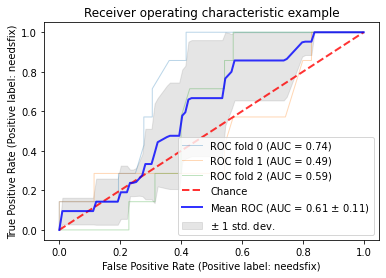

('wmt21-comet-qe-mqm_translation',) 0.30952380952380953


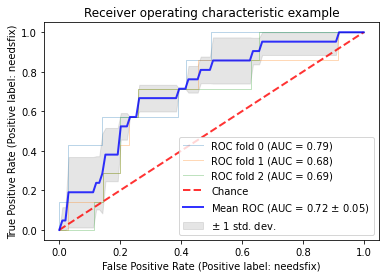

('wmt21-comet-qe-mqm_translation_cubbitt',) 0.3013227513227514


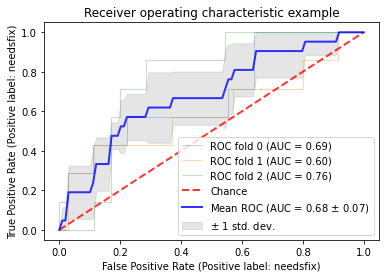

('TransQuest/monotransquest-da-en_any_translation',) 0.3010582010582011


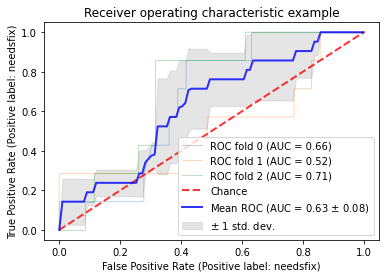

('TransQuest/monotransquest-hter-en_any_translation',) 0.2753968253968254


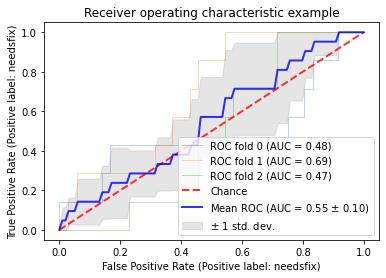

('TransQuest/monotransquest-da-en_any_translation_cubbitt',) 0.2727513227513228


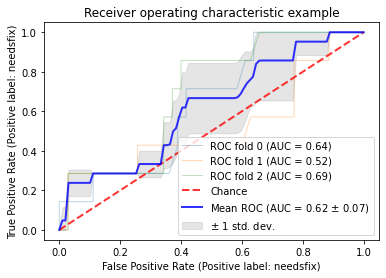

('joeddav/xlm-roberta-large-xnli_trans-gtrans',) 0.2521164021164021


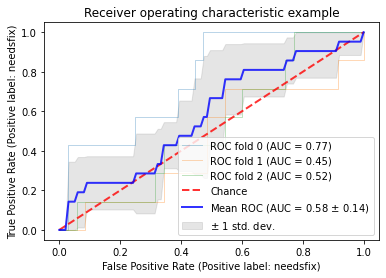

('wmt21-comet-qe-mqm_translation_gtranslate',) 0.2439153439153439


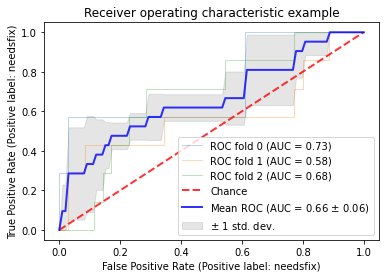

('ctu-aic/xlm-roberta-large-squad2-ctkfacts_trans-cubbitt',) 0.23492063492063495


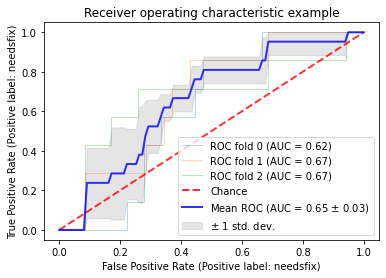

('ctu-aic/xlm-roberta-large-squad2-ctkfacts_source-trans',) 0.1523809523809524


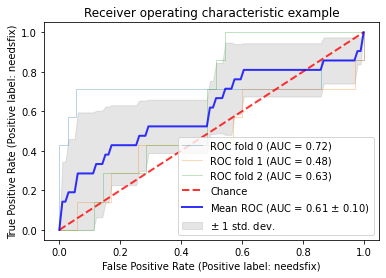

('TransQuest/monotransquest-hter-en_any_translation_cubbitt',) 0.14285714285714282


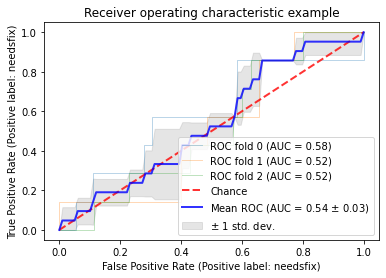

('joeddav/xlm-roberta-large-xnli_trans-cubbitt',) 0.12328042328042328


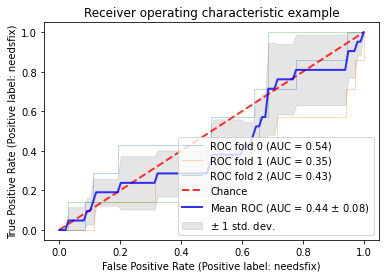

('deepset/xlm-roberta-large-squad2_trans-cubbitt',) 0.12328042328042328


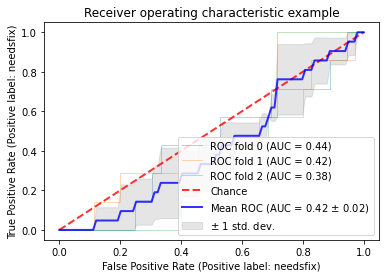

('deepset/xlm-roberta-large-squad2_trans-gtrans',) 0.10343915343915344


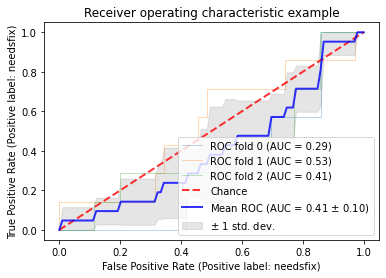

('TransQuest/monotransquest-hter-en_any_translation_gtranslate',) 0.08492063492063495


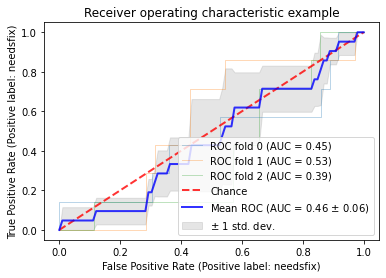

In [ ]:
from itertools import combinations

select_num_columns = 1

cv = StratifiedKFold(n_splits=3)

mean_aucs = []
for feature_comb in combinations(feature_columns, select_num_columns):
    X = prepare_features(human_filtered, feature_comb)
    mean_auc = evaluate_auc(X, y, cv)
    mean_aucs.append((feature_comb, mean_auc))

mean_aucs = sorted(mean_aucs, key=lambda x:x[1], reverse=True)
for feature_comb, mean_auc in mean_aucs[:15]:
    X = prepare_features(human_filtered, feature_comb)
    print(feature_comb, mean_auc)
    evaluate_features(X, y, cv)
    # print(feature_comb)

In [ ]:

def evaluate(self, dataset, target_name):
    nli_outputs, target = self.predict(dataset, target_name, direction)
    if target_name == "adequacy":
        target = np.array(dataset["adequacy"])
    elif target_name == "fluency":
        target = np.array(dataset["fluency"])
    elif target_name == "both":
        target = (np.array(dataset["adequacy"])+np.array(dataset["fluency"]))/2

    # y = (np.array(target) != 5).astype(float)
    y = ["good" if val == 5 else "bad" for val in target]
    X = np.array(nli_outputs)
    model = LogisticRegression(class_weight="balanced").fit(X, y)
    y_pred = model.predict(X)
    #print(y_pred, y)
    # print(f"F1 score {sklearn.metrics.f1_score(y, y_pred, labels=['good', 'bad'])}")
    # print(f"Recall {sklearn.metrics.recall_score(y, y_pred)}")
    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    disp = PrecisionRecallDisplay.from_estimator(
        model, X, y
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    plt.show()
    #disp.plot()

    return
    #return y_pred, y

target: adequacy
direction: en2cz


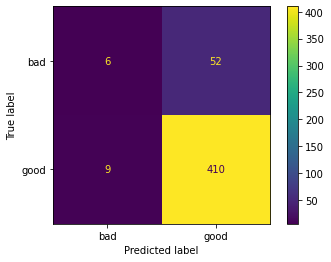

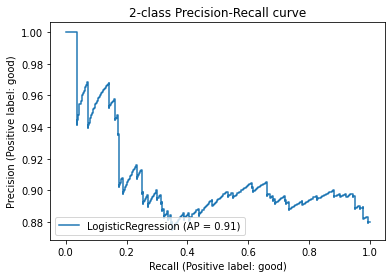

target: adequacy
direction: cz2en


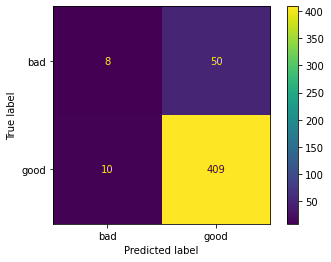

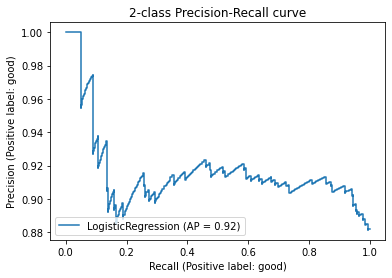

target: adequacy
direction: both


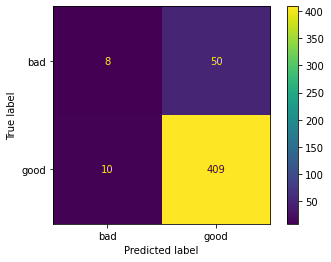

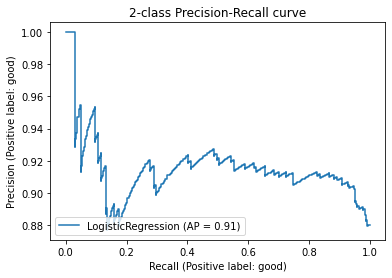

target: fluency
direction: en2cz


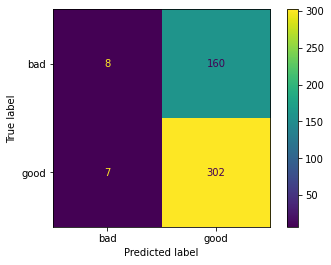

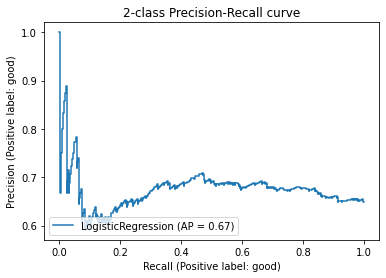

target: fluency
direction: cz2en


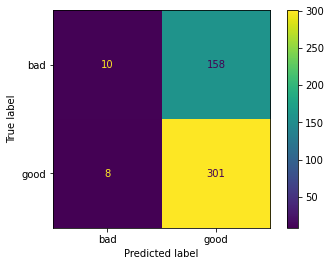

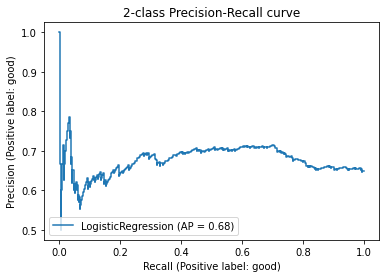

target: fluency
direction: both


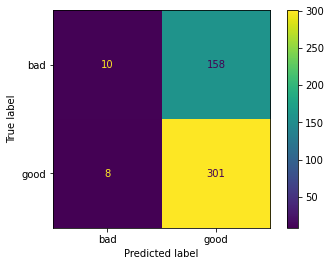

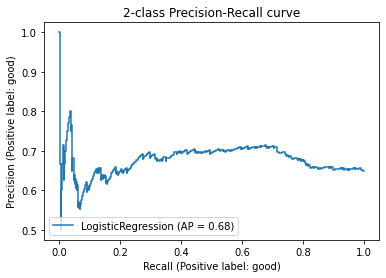

target: both
direction: en2cz


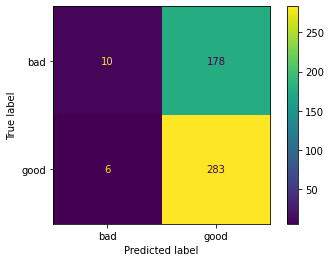

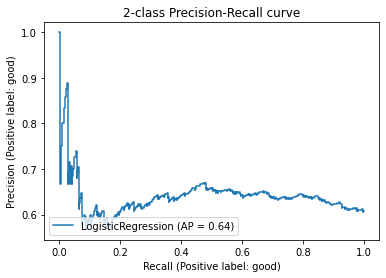

target: both
direction: cz2en


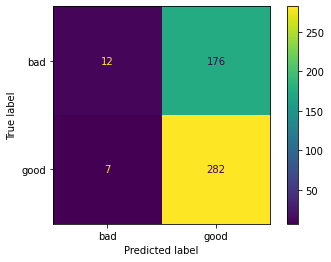

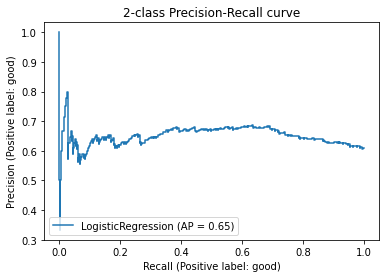

target: both
direction: both


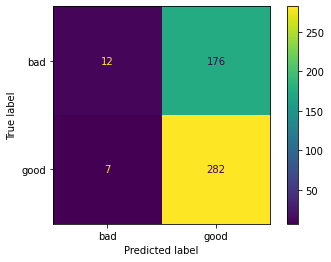

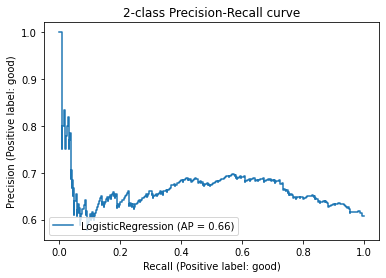

In [ ]:
qp = CzEngNLIQualityPredictor("joeddav/xlm-roberta-large-xnli")
for target in ["adequacy", "fluency", "both"]:
    for direction in ["en2cz", "cz2en", "both"]:
        print(f"target: {target}")
        print(f"direction: {direction}")
        CzEngNLIQualityPredictor.evaluate(qp, human_feedback, target, direction)
        

target: adequacy
direction: en2cz


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2365: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  FutureWarning,


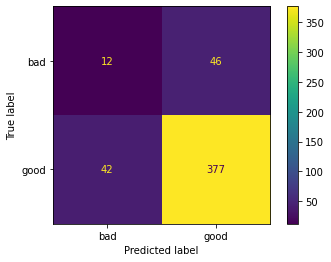

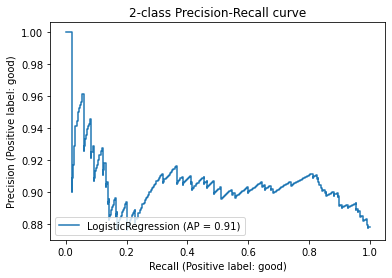

target: adequacy
direction: cz2en


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2365: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  FutureWarning,


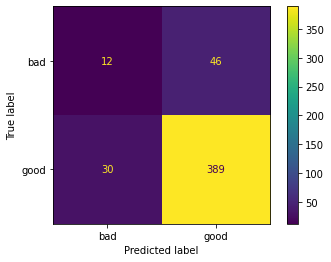

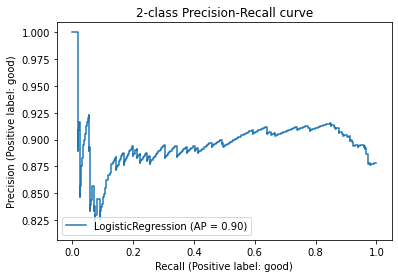

target: adequacy
direction: both


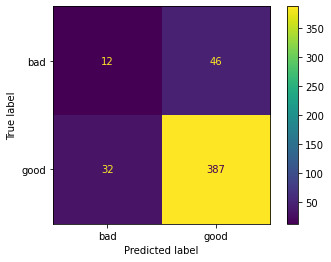

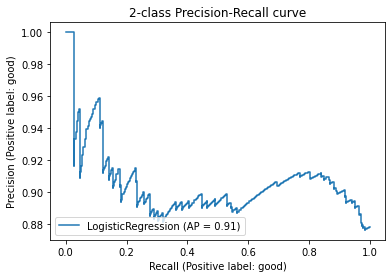

target: fluency
direction: en2cz


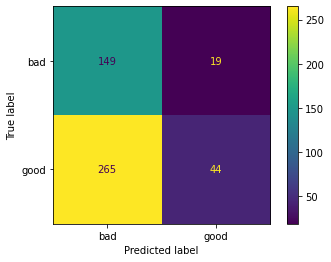

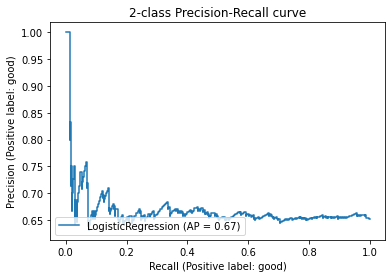

target: fluency
direction: cz2en


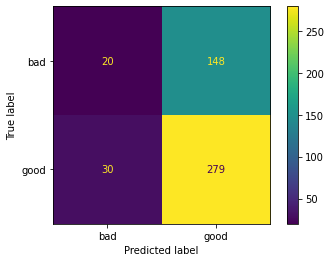

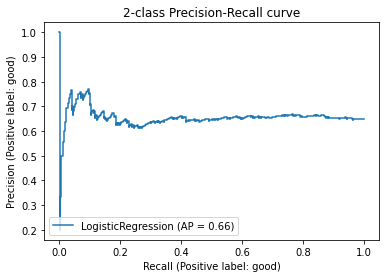

target: fluency
direction: both


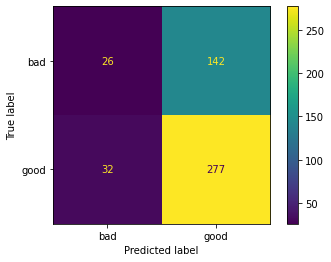

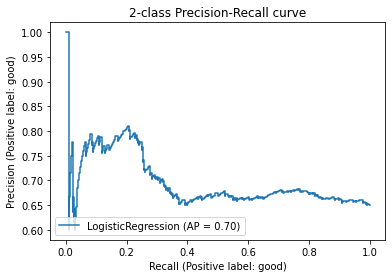

target: both
direction: en2cz


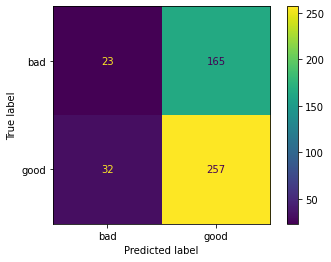

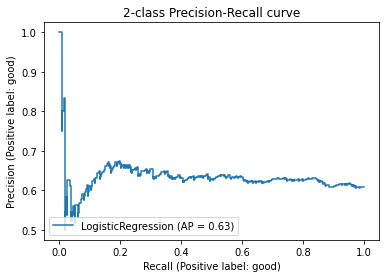

target: both
direction: cz2en


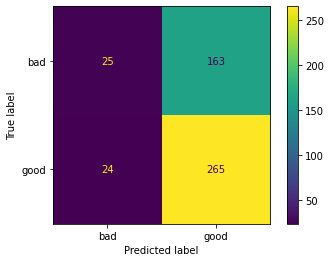

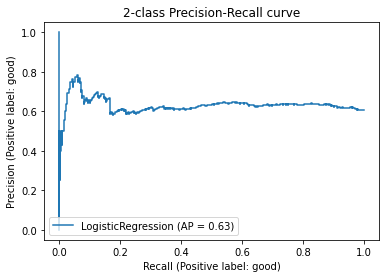

target: both
direction: both


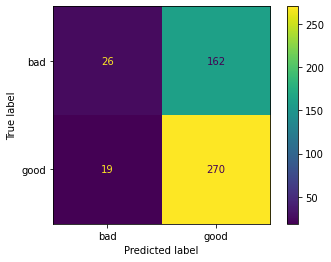

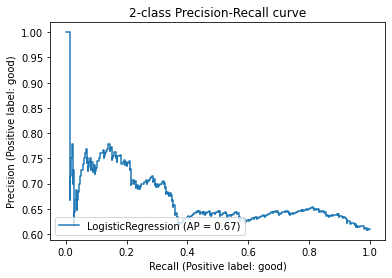

In [ ]:
qp = CzEngNLIQualityPredictor("ctu-aic/xlm-roberta-large-squad2-ctkfacts")
for target in ["adequacy", "fluency", "both"]:
    for direction in ["en2cz", "cz2en", "both"]:
        print(f"target: {target}")
        print(f"direction: {direction}")
        CzEngNLIQualityPredictor.evaluate(qp, human_feedback, target, direction)
        

In [ ]:
CzEngNLIQualityPredictor("deepset/xlm-roberta-large-squad2").evaluate(human_feedback)

Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForSequenceClassification: ['qa_outputs.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'qa_outputs.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at deepset/xlm-roberta-large-squad2 and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'class

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2365: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  FutureWarning,


IndexError: ignored

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2365: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  FutureWarning,


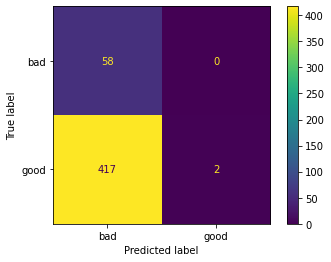

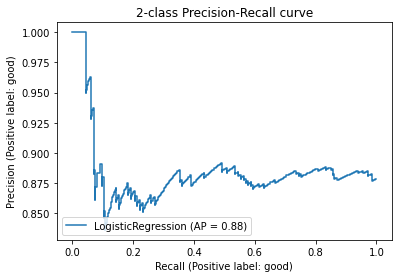

In [ ]:
CzEngNLIQualityPredictor("ctu-aic/xlm-roberta-large-xnli-csfever").evaluate(human_feedback)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2365: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  FutureWarning,


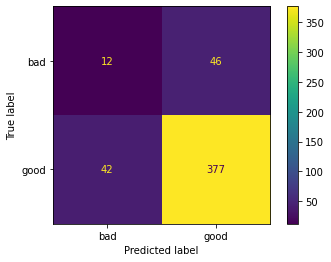

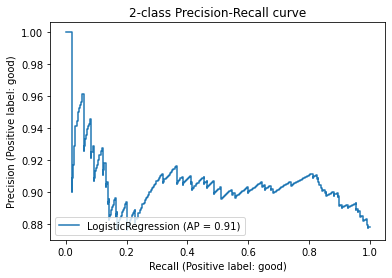

In [ ]:
CzEngNLIQualityPredictor("ctu-aic/xlm-roberta-large-squad2-ctkfacts").evaluate(human_feedback)

## Use NLI to compare the Czech translations to each other

In [ ]:
import pandas as pd
human_feedback = pd.read_csv("drive/MyDrive/diplomka/webnlg_translation_human_feedback.csv")

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from sklearn.linear_model import LogisticRegression
import sklearn
import numpy as np
from functools import lru_cache
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'
class CzNLIQualityPredictor:
    def __init__(self, model_name):
        self.model_name = model_name

        self.nli_model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.nli_model.to(device);
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    @lru_cache(maxsize=1000)
    def nli(self, premise, hypothesis):
        # run through model pre-trained on MNLI
        x = self.tokenizer.encode(premise, hypothesis, return_tensors='pt',
                            truncation_strategy='only_first')
        logits = self.nli_model(x.to(device))[0]
        
        probs = logits.softmax(dim=1)
        # prob_label_is_true = probs[:,1]
        return probs[0].cpu().detach().numpy()
        
    def predict(self, dataset, target_name, direction):
        nli_outputs = []
        if target_name == "adequacy":
            target = np.array(dataset["adequacy"])
        elif target_name == "fluency":
            target = np.array(dataset["fluency"])
        elif target_name == "both":
            target = (np.array(dataset["adequacy"])+np.array(dataset["fluency"]))/2

        for translation, translation_gtranslate, translation_cubbitt in zip(dataset["translation"], dataset["translation_gtranslate"], dataset["translation_cubbitt"]):
            if direction == "deepl2rest":
                features = list(self.nli(translation, translation_gtranslate)) + list(self.nli(translation, translation_cubbitt))
            elif direction == "rest2deepl":
                features = list(self.nli(translation_gtranslate, translation)) + list(self.nli(translation_cubbitt, translation))
            elif direction == "both":
                features = list(self.nli(translation, translation_gtranslate)) + list(self.nli(translation, translation_cubbitt)) + list(self.nli(translation_gtranslate, translation)) + list(self.nli(translation_cubbitt, translation))
            nli_outputs.append(np.array(features))
        return nli_outputs, target

    def evaluate(self, dataset, target_name, direction):
        nli_outputs, target = self.predict(dataset, target_name, direction)
        y = ["good" if val == 5 else "bad" for val in target]
        X = np.array(nli_outputs)

        model = LogisticRegression(class_weight="balanced").fit(X, y)
        y_probs = model.predict_proba(X)
        sklearn.metrics.precision_recall_curve(y, y_probs, pos_label="good")
        #print(y_pred, y)
        # print(f"F1 score {sklearn.metrics.f1_score(y, y_pred, labels=['good', 'bad'])}")
        # print(f"Recall {sklearn.metrics.recall_score(y, y_pred)}")
        #cm = confusion_matrix(y, y_pred, labels=model.classes_)
        #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        #disp.plot()
        #plt.show()

        disp = PrecisionRecallDisplay.from_estimator(
            model, X, y
        )
        _ = disp.ax_.set_title("2-class Precision-Recall curve")
        plt.show()


In [ ]:
qp = CzNLIQualityPredictor("ctu-aic/xlm-roberta-large-squad2-ctkfacts")

RuntimeError: ignored

In [ ]:
for target in ["adequacy", "fluency", "both"]:
    for direction in ["deepl2rest", "rest2deepl", "both"]:
        print(f"target: {target}")
        print(f"direction: {direction}")
        CzNLIQualityPredictor.evaluate(qp, grouped_human_feedback, target, direction)
        

64541